In [130]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import os,sys
sys.path.append('../')

## Math and dataFrame
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

import matplotlib.pyplot as plt

#ML
from sklearn.model_selection import cross_val_predict, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Input, LSTM
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.models import Model
from keras.preprocessing.text import Tokenizer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
label_cols = ['toxic', 'severe_toxic', 'obscene',  'threat', 'insult', 'identity_hate']
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

train['dirtyness'] = train.apply(lambda x: x.iloc[2::].sum(), axis = 1)
test['dirtyness'] = test.apply(lambda x: x.iloc[2::].sum(), axis = 1)

COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

print("train set len ", len(train) )
print("test set len ", len(test) )
print("clean samples", len(train[train['dirtyness'] == 0]))
print("toxic samples", len(train[train['dirtyness'] != 0]))

train set len  159571
test set len  153164
clean samples 143346
toxic samples 16225


In [209]:
#save
modelType = 'LSTM'
modelSubTypeList = ['MultiClass_Embedding_Random']
modelSubType = '_'.join(modelSubTypeList)
modelName = modelType + '_' + modelSubType + '_arch1'

batch_size = 64
epochs = 8

In [210]:
# tokenize
max_features = 20000
maxlen = 100
embedding_dims = 50
filters = 120
hidden_dims = 50
kernel_size = 3

#preprocessing
raw_text = np.hstack([train.comment_text.str.lower(), test.comment_text.str.lower()])
tok_raw = Tokenizer(num_words=max_features)
tok_raw.fit_on_texts(raw_text)

train["seq"] = tok_raw.texts_to_sequences(train.comment_text.str.lower())
test["seq"] = tok_raw.texts_to_sequences(test.comment_text.str.lower())

#sequence.pad_sequences(train['comment_text'].values, maxlen=maxlen)
#test['comment_text'] = sequence.pad_sequences(test['comment_text'], maxlen=maxlen)
#print('x_train shape:', train['comment_text'].values.shape)
#print('x_test shape:', test['comment_text'].values.shape)

In [211]:
# pad
#train["seq"].apply(lambda x: len(x)).describe()
train["seq_pad"] = train["seq"].apply(lambda x, maxlen: sequence.pad_sequences([x], maxlen=maxlen)[0], args = [maxlen])
test["seq_pad"] = test["seq"].apply(lambda x, maxlen: sequence.pad_sequences([x], maxlen=maxlen)[0], args = [maxlen])


In [212]:
# load fe , we will use resample to balance the labels
trn_2nd_input = None
test_2nd_input = None

if modelType == 'LSTMWithKeyWordTermFreq':
    from models.FeatureExtraction import FeatureExtraction

    fe = FeatureExtraction()

    keyword_dir = '../../ZhiHaoSun/'
    keyfiles = [
                keyword_dir + 'toxic_words.txt',
                keyword_dir + 'identity_hate_words.txt',
                keyword_dir + 'insult_words.txt',
                keyword_dir + 'obscene_words.txt',
                keyword_dir + 'threat_words.txt',
                keyword_dir + 'identity_hate_words.txt',
                ]

    term_doc = fe.tfKeyWordEnsemble(
                pd.concat([train, test]), n_feature = 80000, vocabfile = keyfiles,
                COMMENT = 'comment_text'
                )

    trn_term_doc = term_doc.tocsr()[0:len(train), :]
    test_term_doc = term_doc.tocsr()[len(train)::, :]
    trn_2nd_input = trn_term_doc
    test_2nd_input = test_term_doc
    
    aux_input_dim = trn_2nd_input.shape[1]


In [213]:
#build model
def buildModel(modelType):
    if modelType == 'CNN1d':

        model = Sequential()

        # we start off with an efficient embedding layer which maps
        # our vocab indices into embedding_dims dimensions
        model.add(Embedding(max_features,
                            embedding_dims,
                            input_length=maxlen, 
                            #embeddings_regularizer = keras.regularizers.l1(0.01)
                            ))
        model.add(Dropout(0.3))

        # we add a Convolution1D, which will learn filters
        # word group filters of size filter_length:
        model.add(Conv1D(filters,
                         kernel_size,
                         padding='valid',
                         activation='relu',
                         strides=1))
        model.add(BatchNormalization())
        # we use max pooling:
        model.add(GlobalMaxPooling1D())

        # We add a vanilla hidden layer:
        model.add(Dense(hidden_dims))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Activation('relu'))

        # We project onto a single unit output layer, and squash it with a sigmoid:
        model.add(Dense(6))
        model.add(Activation('sigmoid'))

        # define metrics and compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    
    elif modelType == 'LSTM':
        inp = Input(shape=(maxlen,))
        x = Embedding(max_features, embedding_dims)(inp)
        x = Bidirectional(LSTM(hidden_dims, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
        x = GlobalMaxPool1D()(x)
        
        x = Dense(hidden_dims, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(6, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    elif modelType == 'LSTMWithKeyWordTermFreq':
        inp = Input(shape=(maxlen,))
        x = Embedding(max_features, embedding_dims)(inp)
        x = Bidirectional(LSTM(hidden_dims, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
        x = GlobalMaxPool1D()(x)
                
        auxiliary_input = Input(shape=(aux_input_dim,), name='aux_input')
        x = keras.layers.concatenate([x, auxiliary_input])

        x = Dense(hidden_dims, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(6, activation="sigmoid")(x)
        model = Model(inputs=[inp, auxiliary_input], outputs=x)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        
    else:
        raise ValueError("undefined model type")
    
    return model

model = buildModel(modelType)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 100)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_30 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 6)                 306       
Total para

In [214]:
# load fe , we will use resample to balance the labels
from models.FeatureExtraction import FeatureExtraction

fe = FeatureExtraction()

trainOrig = np.array(train['seq_pad'].tolist())
assert(trainOrig.shape == (len(train), maxlen))

train2ndOrig = trn_2nd_input

In [215]:
#define F1 metric
import keras
#fit
reSample = False

# train test split
if reSample == True:
    assert(train2ndOrig is None)
    trn_re, label_re = fe.reSample( scipy.sparse.csr_matrix(trainOrig) , y = train[label_cols].values)
else:
    trn_re, label_re = scipy.sparse.csr_matrix(trainOrig), train[label_cols].values
    train2nd_re = train2ndOrig
    
#x_train, x_val, y_train, y_val = train_test_split(trn_re, label_re, train2ndOrig, test_size=0.33, random_state=42)
y_train = label_re
if modelType == 'LSTMWithKeyWordTermFreq':
    x_train = [trn_re, x_train_2nd]
else:
    x_train = trn_re


# add check point
filepath= type(model).__name__ + "_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
esCallback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
callbacks_list = [checkpoint, esCallback]

hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          #validation_data=(x_val, y_val), 
          validation_split=0.2,
          callbacks=callbacks_list
             )


Train on 127656 samples, validate on 31915 samples
Epoch 1/8
127616/127656 [============================>.] - ETA: 0s - loss: 0.0813 - acc: 0.9741
Epoch 00001: val_loss improved from -inf to 0.05128, saving model to Model_weights_best.hdf5
127656/127656 [==============================] - 287s 2ms/step - loss: 0.0813 - acc: 0.9741 - val_loss: 0.0513 - val_acc: 0.9817
Epoch 2/8
127616/127656 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9824
Epoch 00002: val_loss did not improve
127656/127656 [==============================] - 281s 2ms/step - loss: 0.0479 - acc: 0.9824 - val_loss: 0.0491 - val_acc: 0.9821
Epoch 3/8
127616/127656 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9837
Epoch 00003: val_loss did not improve
127656/127656 [==============================] - 349s 3ms/step - loss: 0.0437 - acc: 0.9837 - val_loss: 0.0504 - val_acc: 0.9821
Epoch 4/8
127616/127656 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9844
Epoch 000

In [216]:
#print(len(y_val))
#print(len(y_val[ [ not np.array_equal(i, np.array([0,0,0,0,0,0])) for i in y_val], : ]) )

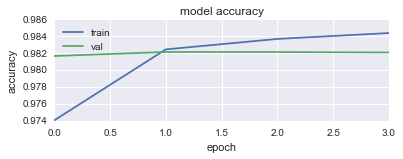

In [217]:
history = hist
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  

In [218]:
# implement Trained Model
from models.TrainedModel import TrainedModel
import modelDB

class TrainedModelCNNEmbeddingMultiClass(TrainedModel):
    def __init__(self, md = None):
        super(TrainedModelCNNEmbeddingMultiClass, self).__init__(md)
    
    def predict(self, test, **kwargs):
        print ("Predict using Model: ")
        print( type(self.md).__name__ )
            
        res = self.md.predict(test, batch_size = 1024)
        #important to keep the order as required by the submission file
        testid = kwargs['testid'] 
        #print (testid)
        dfres = pd.DataFrame(res,columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate'])
        dfres['id'] = testid
        
        #print(dfres.shape)
        #assert(dfres.shape[0] == test.shape[0])
        
        #reshape to submission file format
        dfres = dfres[['id', 'toxic','severe_toxic','obscene','threat','insult','identity_hate']]
        
        return dfres
    
    def _save(self, mDB, nameKey, modelpath, **kwargs):
        '''
        save model into model data base
        :mDB: meta data frame storing all models info
        :nameKey: unique identifier for each saved model
        :modelpath: subdir inside modelDB dir, e.g. if modelDB is /root/modelDB, then modelpath is /cnn
        '''
        print("Saving model")
        import datetime
        
        #save a dict (topic => ('modelname', 'weightname')) into db
        model_saved_toDB = {}
        
        submd = self.md
        #this is the file we will save model to
        mdname = os.path.join(modelpath, nameKey +'_' + '.sav' )
        mdnameAbs = os.path.join(modelDB.MODEL_DB_ROOT, mdname )

        #this is the file we will save weights to
        weightName = os.path.join(modelpath, nameKey + '_' + '_weights.h5' )
        weightNameAbs = os.path.join( modelDB.MODEL_DB_ROOT, weightName )

        #convert md to json and save to file
        print(" Saving model {}".format(mdname) )
        model_json = submd.to_json()
        with open(mdnameAbs, "w") as json_file:
            json_file.write(model_json)

        # serialize weights to HDF5
        print(" Saving weights {}".format(weightName) )
        submd.save_weights(weightNameAbs)
    
        model_saved_toDB['MultiClassModel'] = (mdname, weightName)
            
        
        #db schema
        # 'modelName', type {rnn, cnn, rf}, date, model
        print( "Info: custom saving options" )
        for i in kwargs:
            print("{} - {}".format(i , kwargs[i]))
            
        import json
        newRow = pd.DataFrame({
            'modelName': [nameKey],
            'type': kwargs['modelType'],
            'subType': kwargs['modelSubType'],
            'date': str(datetime.datetime.now().strftime("%Y-%m-%d")),
            'model' : json.dumps(model_saved_toDB)
        }
        )
        
        #add a new row 
        #mDB = pd.concat([mDB, newRow])
        mDB = mDB.append(newRow, ignore_index = True)
        display(mDB)

        return mDB
    
    def load(self, mDB, nameKey, modelpath):
        '''
        :mDB: meta data frame storing all models info
        :nameKey: unique identifier for each saved model
        :modelpath: subdir inside modelDB dir, e.g. if modelDB is /root/modelDB, then modelpath is /cnn
        '''
        from keras.models import model_from_json
        import json
        
        if (mDB.empty) or mDB[ mDB['modelName'] == nameKey ].empty:
            raise VaueError("Model name does not exist")
        print("loadModel")
        #the saved model is of format: dict (topic => ('modelname', 'weightname')) into db
        assert(len(mDB[mDB['modelName'] == nameKey]) == 1)
        saved_model_inDB = json.loads(mDB[mDB['modelName'] == nameKey].iloc[0]['model'])
        
        print("saved json string representing the model is {}".format(saved_model_inDB))

        key = 'MultiClassModel'
        mdPointer = saved_model_inDB[key]
        print(" load model")
        mdname = mdPointer[0]
        mdnameAbs = os.path.join(modelDB.MODEL_DB_ROOT, mdname )
        print("  model file in {}".format(mdnameAbs))

        #this is the file we will save weights to
        weightName = mdPointer[1]
        weightNameAbs = os.path.join( modelDB.MODEL_DB_ROOT, weightName )
        print("  weight file in {}".format(weightNameAbs))
            
        with open(mdnameAbs, 'r') as json_file:
            tmpModel_json = json_file.read()
        tmpModel = model_from_json(tmpModel_json)
            #load weights
        tmpModel.load_weights(weightNameAbs)
            
            #assign the model into loaded model dict
        loaded_model = tmpModel
        
        assert(self.md is None)
        self.setModel(loaded_model)
        return self



In [ ]:
#Utest test predict
if modelType == 'LSTMWithKeyWordTermFreq':
    utestInput = [trainOrig[0:1000, :], train2ndOrig[0:1000,:]]
else:
    utestInput = trainOrig[0:1000, :]


myCNN1d = TrainedModelCNNEmbeddingMultiClass(model)
dfres = myCNN1d.predict(utestInput, testid = train['id'])
display(dfres.head(20))
display(train.head(20)[['id', 'toxic','severe_toxic','obscene','threat','insult','identity_hate']])

#Utest test save
mdDB = pd.read_pickle("../modelDB/modelMetaDB.pkl")
modelpath = 'cnn/' # NOTE: this is relative to the modelDB path
print("current modelDB")
display(mdDB)

mdDB = myCNN1d.save(mdDB, 'utestModel', modelpath, modelType = 'CNN1d', modelSubType = 'Embedding_Random')
#mdDB.to_json("../modelDB/modelMetaDB.json")

#Utest test load
loadedCNN = TrainedModelCNNEmbeddingMultiClass().load( mdDB, 'utestModel', modelpath)
dfres_loaded = loadedCNN.predict(utestInput, testid = train['id'])
assert(dfres_loaded.equals(dfres))

In [220]:
#forward pass to inference
if modelType == 'LSTMWithKeyWordTermFreq':
    testOrig = [np.array(test['seq_pad'].tolist()), test_2nd_input]
else:
    testOrig = np.array(test['seq_pad'].tolist())


myCNN1d = TrainedModelCNNEmbeddingMultiClass(model)

dfres = myCNN1d.predict(testOrig, testid = test['id'])

Predict using Model: 
Model


In [221]:
myCNN1d = TrainedModelCNNEmbeddingMultiClass(model)

mdDB = pd.read_pickle("../modelDB/modelMetaDB.pkl")
modelpath = 'cnn/' # NOTE: this is relative to the modelDB path
#print("current modelDB")
#display(mdDB)
mdDB = myCNN1d.save(mdDB, modelName, modelpath, modelType = modelType, modelSubType = modelSubType)
mdDB.to_pickle("../modelDB/modelMetaDB.pkl")


Saving model
 Saving model cnn/LSTM_MultiClass_Embedding_Random_arch1_.sav
 Saving weights cnn/LSTM_MultiClass_Embedding_Random_arch1__weights.h5
Info: custom saving options
modelSubType - MultiClass_Embedding_Random
modelType - LSTM


,date,model,modelName,subType,type,weights
0,1970-01-01 00:00:00,"{""severe_toxic"": [""cnn/CNN1d-Embedding_Random-...",CNN1d-Embedding_Random-OneperClass,Embedding_Random,CNN1d,NaN
1,1970-01-01 00:00:00,cnn/utestModel.sav,utestModel,TfIdf,testType,NaN
2,2018-02-13,"{""severe_toxic"": [""cnn/CNN1d-Embedding_Random-...",CNN1d-Embedding_Random-OneperClass_arch1,Embedding_Random,CNN1d,NaN
3,2018-02-13,svc/SVC_tfidf_1.sav,SVC_tfidf_1,TfIdf,SVC,NaN
4,2018-02-13,svc/SVC_keywordTermFreq_1.sav,SVC_keywordTermFreq_1,TfIdf,SVC,NaN
5,2018-02-14,"{""severe_toxic"": [""cnn/CNN1d-Embedding_Random-...",CNN1d-Embedding_Random-OneperClass_arch2,Embedding_Random,CNN1d,NaN
6,2018-02-14,"{""MultiClassModel"": [""cnn/CNN1d_MultiClass_Emb...",CNN1d_MultiClass_Embedding_Random_arch1,MultiClass_Embedding_Random,CNN1d,NaN
7,2018-02-17,"{""MultiClassModel"": [""cnn/LSTMWithKeyWordTermF...",LSTMWithKeyWordTermFreq_MultiClass_Embedding_R...,MultiClass_Embedding_Random,LSTMWithKeyWordTermFreq,NaN
8,2018-02-17,"{""MultiClassModel"": [""cnn/LSTM_MultiClass_Embe...",LSTM_MultiClass_Embedding_Random_arch1,MultiClass_Embedding_Random,LSTM,NaN


In [222]:
#save
dfres.to_csv('../submission/'+modelName+'.csv', index = False)